# APS 2 - Transferência de Calor e Mecânica dos Sólidos

## Enunciado

Considere uma aleta de seção transversal circular e constante, com temperatura fixa na base e exposta ao ambiente em todas as outras superfícies. Podemos esboçar as entradas e saídas de energia em um volume de controle definido ao redor de uma seção como indica a Fig.1.

<img src="./enunciado.jpeg" />

- $q_x$ taxa de transferência de calor por condução em $x$.
- $q_{x + dx}$ taxa de transferência de calor por condução em $x + dx$.
- $dq_{conv}$ taxa de transferência de calor por convecção através da área superficial do elemento diferencial.

Substituindo as equações de taxa $q_x$, $q_{x + dx}$ e $dq_{conv}$ podemos obter a forma geral da equação da energia para uma 
superfície estendida, em regime transiente como: 

<img src="./eq.jpeg">

## Roteiro

- Aplique os conceitos do método das diferenças finitas na equação diferencial do problema para definir uma equação de diferença algébrica associada aos nós da aleta. Considere para a segunda derivada da temperatura no espaço uma equação de diferença finita centrada e para a primeira derivada no tempo da temperatura uma equação de diferença progressiva. Apresente o desenvolvimento das equações.

- Apresente um gráfico ($Temperatura \times posição$) após obter o regime permanente. Use uma tolerância de $tol = 1 \cdot10^{-10}$. Considere que a aleta, de comprimento $L = 300mm$ , densidade de $2700 kg/m^3$ , condutividade térmica de $180 W/(mK)$ e calor específico $896 J/(kg K)$, tem a temperatura especificada na extremidade de $T(L) = 25 °C$. A aleta está em contato com uma base a $𝑇_b = 100℃$ em um ambiente a $𝑇_{\infty} = 50 °C$ e $h = 50W/m^2K$. Para a condição de estabilidade do procedimento numérico use $\Delta t \leq \frac{\Delta x^2}{\alpha \cdot \left(\frac{h P \Delta x^2}{k A_{tr}} + 2 \right) }$.

- Para validar os resultados obtidos com o software desenvolvido, apresente um gráfico ($Temperatura \times posição$) para o comportamento analítico da temperatura na aleta usando as mesmas condições definidas no item anterior.

### Bibliotecas necessárias

In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt

### Parâmetros e constantes iniciais fornecidas

In [2]:
# Tolerância
tol = 1e-10

# Comprimento da aleta (m)
L = 0.3

# Densidade (kg / m^3)
dens = 2700

# Condutividade térmica (W/m.K)
k = 180

# Calor específico (J/kg.K)
c = 896

# Temperatura na extremidade (K)
T_L = 25 + 273

# Temperatura da base (K)
T_b = 100 + 273

# Temperatura do ambiente (K)
T_amb = 50 + 273

# Constante de convecção (W / K.m^2)
h = 50


### Parâmetros e constantes definidos para um caso

In [3]:
# Raio da aleta (m)
r = 3e-3

# Delta x (0.1 mm)
dx = 1e-3

# Tempo total (5 min)
t_total = 10 * 60

### Solução numérica

In [4]:
def numeric_solution(dens, c, k, h, T_amb, T_b, r, L, dx, t_total):
    """
        Aplica método numérico para o caso da aleta

        dens = densidade
        c    = calor específico
        k    = condutividade térmica
        h    = coeficiente de convecção
        T_amb = temperatura do fluido
        T_b  = temperatura da base
        r    = raio
        L    = comprimento
        dx   = pedaço de comprimento
        t_total = tempo total da simulação
    """
    # Difusividade
    alpha = k / (dens * c)
    
    # Área transversal
    A_tr = pi * (r**2)

    # Perímetro
    P = 2 * pi * r

    # Passo temporal para condição de estabilidade
    dt = (dx**2) / (alpha * (2 + (h*P*(dx**2)) / (k * A_tr)))
    
    # Lista com nós
    length_list = np.arange(0, L + dx, dx)
    
    # Número de nós
    nn = int(L/dx) + 1

    # Número de passos no tempo
    steps = int(t_total/dt) + 1

    # Matriz de temperaturas
    temp_list = np.zeros((steps, nn))

    # Condições iniciais
    temp_list[:, 0] = T_b
    temp_list[:, 1:nn-2] = T_amb
    temp_list[:, nn-1] = T_L
    
    # Looping do cálculo numérico
    for t in range(0, steps-1):
        for i in range(1, len(length_list) - 1):
            coef_1 = (temp_list[t, i + 1] - (2 * temp_list[t, i]) + temp_list[t, i - 1]) / (dx**2)
            coef_2 = (h * P * (temp_list[t, i] - T_amb)) / (k * A_tr)
            temp_list[t+1, i] = temp_list[t, i] + alpha * dt * (coef_1 - coef_2)
            
    plt.subplot(121)
    plt.title("Distribuição de temperatura  - caso numérico")
    plt.plot(length_list * 10, temp_list[-1, :] - 273, 'g')
    plt.xlabel("Comprimento [cm]")
    plt.ylabel("Temperatura [°C]")
    plt.grid()
    
    diff = abs((temp_list[-1, 10] - temp_list[-2, 10]) / temp_list[-2, 10])
    print(f"Valor obtido: {diff} < {tol}")


### Solução analítica

In [5]:
def analitic_solution(d, c, k, h, T_amb, T_b, r, L, dx, t_total):
    """
        Aplica método analítico para o caso da aleta, com condição
        de contorno para T(L) = T_L fixa na extremidade

        d = densidade
        c = calor específico
        k = condutividade térmica
        h = coeficiente de convecção
        T_amb = temperatura do fluido
        T_b = temperatura da base
        r = raio
        L = comprimento
        dx = pedaço de comprimento
        t_total = tempo total da simulação
    """
    # Área transversal
    A_tr = pi * (r**2)

    # Perímetro
    P = 2 * pi * r

    m            = sqrt((h*P) / (k*A_tr))
    temps        = []
    lista_x      = np.linspace(0, L, 10000)
    theta_l      = T_L - T_amb
    theta_b      = T_b - T_amb

    for x in lista_x:
        numerador   = (theta_l/theta_b)*sinh(m*x) + sinh(m*(L - x))
        denominador = sinh(m*L)
        temperatura = T_amb + (numerador/denominador)*(T_b - T_amb)
        temps.append(temperatura)

    temps_em_c = [T - 273 for T in temps]
    plt.figure(figsize=(15, 4))

    plt.subplot(122)
    plt.plot(lista_x * 100, temps_em_c, 'purple')
    plt.title("Distribuição de temperatura - Caso analítico")
    plt.xlabel("Comprimento (cm)")
    plt.ylabel("Temperatura (°C)")
    plt.grid()

### Gráficos dos resultados numérico e analítico

Valor obtido: 2.4683617528362133e-11 < 1e-10


<Figure size 1080x288 with 0 Axes>

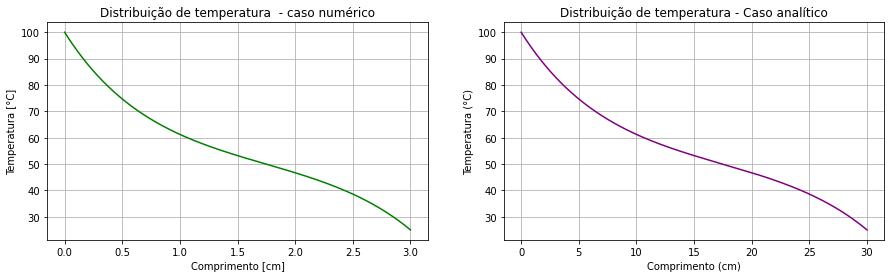

In [6]:
# Gera figura
plt.figure(figsize=(15, 4))

# Plota resultados
analitic_solution(dens, c, k, h, T_amb, T_b, r, L, dx, t_total)
numeric_solution(dens, c, k, h, T_amb, T_b, r, L, dx, t_total)

plt.show()